In [1]:
import numpy as np
import pandas as pd
import math
import random
from collections import defaultdict
from typing import Dict, Set, List, Tuple, Optional, Union
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gdown

## EpiInfer Class

In [2]:
class EpiInferContact:
    """
    Complete implementation of EpiInfer-CONTACT epidemic forecasting system.

    This class implements a non-Markovian approach to forecasting infection rates
    using contact tracing data and meeting distributions.
    """

    def __init__(self, population: List[Union[int, str]],
                 contacts_per_day: Optional[Dict[int, List[Tuple]]] = None,
                 random_seed: Optional[int] = None):
        """
        Initialize the EpiInfer-CONTACT system.

        Parameters
        ----------
        population : List[Union[int, str]]
            List of individual IDs in the population
        contacts_per_day : Optional[Dict[int, List[Tuple]]]
            Contact tracing data: {day: [(person_a, person_b), ...]}
        random_seed : Optional[int]
            Random seed for reproducibility
        """
        self.population = list(population)
        self.pop_set = set(population)
        self.pop_size = len(population)

        # Build adjacency structure from contacts
        self.contacts_adj = self._build_adjacency(contacts_per_day) if contacts_per_day else {}

        # Set random seed if provided
        if random_seed is not None:
            random.seed(random_seed)
            np.random.seed(random_seed)

        # State tracking (initialized during simulation)
        self.BelNewExp = None
        self.BelNewInf = None
        self.BelNewRec = None
        self.BelExp = None
        self.BelInf = None
        self.BelRec = None

    # ========== UTILITY METHODS ==========

    @staticmethod
    def _build_adjacency(contacts_per_day: Dict[int, List[Tuple]]) -> Dict[int, Dict]:
        """
        Convert contact pairs into adjacency dictionary for each day.

        Parameters
        ----------
        contacts_per_day : Dict[int, List[Tuple]]
            {day: [(person_a, person_b), ...]}

        Returns
        -------
        Dict[int, Dict[person, Set[person]]]
            Adjacency structure: {day: {person: {contacts}}}
        """
        adj = {}
        for day, pairs in contacts_per_day.items():
            # Get all unique people in contacts for this day
            people = set()
            for a, b in pairs:
                people.add(a)
                people.add(b)

            # Build adjacency
            day_adj = {p: set() for p in people}
            for a, b in pairs:
                day_adj[a].add(b)
                day_adj[b].add(a)
            adj[day] = day_adj
        return adj

    @staticmethod
    def rmse(y_true: List[float], y_pred: List[float]) -> float:
        """Calculate Root Mean Squared Error."""
        return math.sqrt(mean_squared_error(y_true, y_pred))

    @staticmethod
    def relative_rmse(y_true: List[float], y_pred: List[float]) -> float:
        """Calculate Relative Root Mean Squared Error."""
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        # Avoid division by zero
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            rel_errors = np.where(y_true != 0, (y_pred - y_true) / y_true, 0)
        return float(np.sqrt(np.mean(rel_errors ** 2)))

    def _count_total_contacts(self, person: Union[int, str]) -> int:
        """Count total contacts for a person across all available days."""
        total = 0
        for day_adj in self.contacts_adj.values():
            total += len(day_adj.get(person, set()))
        return total

    # ========== ALGORITHM 3: FINDPROB ==========

    def find_prob_exposure(self, exposed_set: Set, person: Union[int, str],
                          p1: float, day: int) -> float:
        """
        Algorithm 3: Calculate probability that susceptible person becomes exposed.

        Computes: 1 - (1 - p1)^countEncounters
        where countEncounters is the number of contacts with exposed individuals.

        Parameters
        ----------
        exposed_set : Set
            Set of currently exposed (infectious) individuals
        person : Union[int, str]
            Individual to calculate exposure probability for
        p1 : float
            Probability of exposure per single contact with exposed person
        day : int
            Day to check contacts

        Returns
        -------
        float
            Probability of exposure on this day
        """
        if day not in self.contacts_adj:
            return 0.0

        # Get person's contacts on this day
        person_contacts = self.contacts_adj[day].get(person, set())

        # Count encounters with exposed individuals
        encounters = len(person_contacts & exposed_set)

        # Probability: 1 - (1 - p1)^encounters
        return 1.0 - (1.0 - p1) ** encounters if encounters > 0 else 0.0

    # ========== ALGORITHM 2: PREDICT ==========

    def predict_exposures(self, BelExp_d: Set, BelSusc_d: Set,
                         p1: float, day: int) -> Tuple[Set, Dict]:
        """
        Algorithm 2: Probabilistically predict who becomes newly exposed.

        Each susceptible person is independently exposed with probability p,
        where p is calculated based on their contacts with exposed individuals.

        CRITICAL: Uses EXPOSED population as infectious source (pre-symptomatic transmission).

        Parameters
        ----------
        BelExp_d : Set
            Set of exposed (infectious) people on day d
        BelSusc_d : Set
            Set of susceptible people on day d
        p1 : float
            Probability of exposure per contact
        day : int
            Current day

        Returns
        -------
        Tuple[Set, Dict]
            (newly_exposed_set, probability_dict)
        """
        # Calculate exposure probability for each susceptible
        raw_probs = {
            s: self.find_prob_exposure(BelExp_d, s, p1, day)
            for s in BelSusc_d
        }

        # Probabilistic sampling: each person independently exposed
        newly_exposed = set()
        for person, prob in raw_probs.items():
            if prob > 0 and random.random() < prob:
                newly_exposed.add(person)

        return newly_exposed, raw_probs

    # ========== INITIALIZATION HELPER ==========

    def _initialize_exposed_from_infected(self, initial_infected: Set,
                                         p2: float) -> Set:
        """
        Smart initialization of exposed population based on infected count.

        Strategy:
        - Estimate exposed count = len(initial_infected) / p2
        - Assign exposure to individuals with most contacts (highest risk)

        Parameters
        ----------
        initial_infected : Set
            Initially infected individuals
        p2 : float
            Probability that exposed person becomes infected

        Returns
        -------
        Set
            Initially exposed individuals
        """
        if p2 <= 0:
            return set()

        # Estimate number of exposed based on infected count
        estimated_exposed_count = int(round(len(initial_infected) / p2))

        if estimated_exposed_count == 0:
            return set()

        # Exclude already infected from consideration
        candidates = self.pop_set - initial_infected

        if not candidates:
            return set()

        # Count total contacts for each candidate
        contact_counts = {
            person: self._count_total_contacts(person)
            for person in candidates
        }

        # Select top N by contact count
        sorted_candidates = sorted(contact_counts.items(), key=lambda x: -x[1])
        exposed_count = min(estimated_exposed_count, len(sorted_candidates))
        initial_exposed = {person for person, _ in sorted_candidates[:exposed_count]}

        return initial_exposed

    # ========== ALGORITHM 1: CONTACTINFER-CORE ==========

    def contactinfer_core(self, p1: float, p2: float, inc: int,
                         initial_infected: Set,
                         initial_exposed: Optional[Set] = None,
                         max_day: int = 20,
                         duration_infected: int = 7,
                         duration_recovered: int = 14,
                         stochastic: bool = True,
                         verbose: bool = False) -> pd.DataFrame:
        """
        Algorithm 1: Main contact-tracing inference loop.

        Simulates epidemic progression using contact tracing data and
        predicts daily infection counts.

        Parameters
        ----------
        p1 : float
            Probability of exposure per contact with exposed person (0-1)
        p2 : float
            Probability exposed person becomes infected (0-1)
        inc : int
            Incubation period in days
        initial_infected : Set
            Initially infected individuals
        initial_exposed : Optional[Set]
            Initially exposed individuals (if None, estimated from infected)
        max_day : int
            Number of days to simulate
        duration_infected : int
            Days person stays in infected state
        duration_recovered : int
            Days person stays recovered (immune)
        stochastic : bool
            If True, use probabilistic sampling; if False, use expected values
        verbose : bool
            Print progress information

        Returns
        -------
        pd.DataFrame
            Daily statistics with columns: day, new_exposed, new_infected,
            total_exposed, total_infected, total_susceptible, etc.
        """
        # Initialize exposed from infected if not provided
        if initial_exposed is None:
            initial_exposed = self._initialize_exposed_from_infected(
                initial_infected, p2
            )
            if verbose:
                print(f"Initialized {len(initial_exposed)} exposed individuals "
                      f"from {len(initial_infected)} infected (ratio: 1/{p2:.2f})")

        # Initialize tracking dictionaries
        self.BelNewExp = defaultdict(set)
        self.BelNewInf = defaultdict(set)
        self.BelNewRec = defaultdict(set)
        self.BelExp = defaultdict(set)
        self.BelInf = defaultdict(set)
        self.BelRec = defaultdict(set)

        # Day 1 initialization
        self.BelNewExp[1] = set(initial_exposed)
        self.BelNewInf[1] = set(initial_infected)
        self.BelExp[1] = set(initial_exposed)
        self.BelInf[1] = set(initial_infected)
        self.BelRec[1] = set()

        records = []

        for d in range(1, max_day + 1):
            # Current state
            exp_d = self.BelExp[d]
            inf_d = self.BelInf[d]
            rec_d = self.BelRec[d]

            # Susceptible = Everyone - (Exposed ∪ Infected ∪ Recovered)
            susc_d = self.pop_set - (exp_d | inf_d | rec_d)

            # Algorithm 2: Predict new exposures
            # CRITICAL: Use EXPOSED as infectious source (pre-symptomatic transmission)
            new_exp, raw_probs = self.predict_exposures(exp_d, susc_d, p1, d)
            self.BelNewExp[d + 1] = new_exp

            # Active exposed = exposures within incubation window
            window_exp = range(max(1, d + 1 - inc + 1), d + 2)
            active_exp = set().union(*[self.BelNewExp[t] for t in window_exp])
            self.BelExp[d + 1] = active_exp

            # Algorithm 1 Line 8: Infections from exposures inc days ago
            src_day = d + 1 - inc
            new_inf = set()

            if src_day >= 1:
                old_exp = self.BelNewExp[src_day]

                if stochastic:
                    # Each individual becomes infected with probability p2
                    new_inf = {e for e in old_exp if random.random() < p2}
                else:
                    # Deterministic approximation using expected value
                    k = int(round(p2 * len(old_exp)))
                    if k > 0 and old_exp:
                        new_inf = set(random.sample(list(old_exp),
                                                   min(k, len(old_exp))))

            self.BelNewInf[d + 1] = new_inf

            # Active infections = all infections within duration window
            window_inf = range(max(1, d + 1 - duration_infected + 1), d + 2)
            active_inf = set().union(*[self.BelNewInf[t] for t in window_inf])
            self.BelInf[d + 1] = active_inf

            # Track recoveries
            recovery_day = d + 1 - duration_infected
            if recovery_day >= 1:
                new_rec = self.BelNewInf[recovery_day]
                self.BelNewRec[d + 1] = new_rec
            else:
                self.BelNewRec[d + 1] = set()

            # Active recovered = all recoveries within duration window
            window_rec = range(max(1, d + 1 - duration_recovered + 1), d + 2)
            active_rec = set().union(*[self.BelNewRec[t] for t in window_rec])
            self.BelRec[d + 1] = active_rec

            records.append({
                "day": d,
                "new_exposed": len(new_exp),
                "new_infected": len(new_inf),
                "new_recovered": len(self.BelNewRec[d + 1]),
                "total_exposed": len(self.BelExp[d + 1]),
                "total_infected": len(self.BelInf[d + 1]),
                "total_recovered": len(self.BelRec[d + 1]),
                "total_susceptible": len(susc_d),
                "expected_new_exposed": sum(raw_probs.values())
            })

        return pd.DataFrame(records)

    # ========== ALGORITHM 4: EPIINFER-CORE ==========

    def epiinfer_core(self, p1: float, p2: float, inc: int,
                     NewInf_hist: Dict[int, int],
                     asymp_hist: Dict[int, int],
                     recovered_hist: Dict[int, int],
                     mean_meetings: Dict[int, float],
                     max_day: int) -> Dict[int, int]:
        """
        Algorithm 4: Meeting-distribution based inference.

        Uses aggregate meeting statistics instead of individual contact tracing.

        Parameters
        ----------
        p1 : float
            Probability of exposure per contact
        p2 : float
            Probability exposed becomes infected
        inc : int
            Incubation period
        NewInf_hist : Dict[int, int]
            Historical new infections by day
        asymp_hist : Dict[int, int]
            Historical asymptomatic count by day
        recovered_hist : Dict[int, int]
            Historical recovered count by day
        mean_meetings : Dict[int, float]
            Mean number of meetings per person by day
        max_day : int
            Maximum day to predict

        Returns
        -------
        Dict[int, int]
            Predicted new infections by day
        """
        NewInf = defaultdict(int, NewInf_hist)
        asymp = defaultdict(int, asymp_hist)
        recovered = defaultdict(int, recovered_hist)
        preds = {}

        for d in range(1, max_day + 1):
            t = d - inc

            if t < 1:
                preds[d] = NewInf.get(d, 0)
                continue

            # Equation (1): Probability already exposed
            numerator = sum(NewInf.get(d - i, 0) for i in range(1, inc + 1))
            denominator = p2 * max(1, asymp[t])
            palreadyexp = min(numerator / denominator, 1.0) if denominator > 0 else 0

            # Equation (2): Probability newly exposed
            mean_contacts = mean_meetings.get(t, 0)
            p_newexposed = 1 - (1 - p1) ** (mean_contacts * palreadyexp)

            # Equation (3): Asymptomatic not exposed
            already_exposed_count = numerator / p2 if p2 > 0 else 0
            asymptomaticNotEx = (asymp[t] - already_exposed_count
                               - recovered.get(t, 0))
            asymptomaticNotEx = max(0, asymptomaticNotEx)

            # Equation (4) & (5): New exposures and infections
            NewExposed = asymptomaticNotEx * p_newexposed
            preds[d] = int(round(p2 * NewExposed))
            NewInf[d] = preds[d]

        return preds

    # ========== ALGORITHM 5: CONTINUOUSCALIBRATE ==========

    def continuous_calibrate(self, observed_newinf: Dict[int, int],
                           inc: int,
                           mean_meetings: Dict[int, float],
                           asymp_hist: Optional[Dict[int, int]] = None,
                           recovered_hist: Optional[Dict[int, int]] = None,
                           p2_values: Optional[List[float]] = None,
                           training_window: int = 5,
                           binary_search_iterations: int = 15,
                           verbose: bool = False) -> Dict[str, float]:
        """
        Algorithm 5: Find optimal p1 and p2 parameters via grid/binary search.

        For each p2 value, performs binary search on p1 to minimize RMSE.

        Parameters
        ----------
        observed_newinf : Dict[int, int]
            Observed new infections by day
        inc : int
            Incubation period
        mean_meetings : Dict[int, float]
            Mean meetings per person by day
        asymp_hist : Optional[Dict[int, int]]
            Asymptomatic population by day (defaults to total population)
        recovered_hist : Optional[Dict[int, int]]
            Recovered population by day (defaults to 0)
        p2_values : Optional[List[float]]
            List of p2 values to test (defaults to 0.1 to 1.0 in 0.1 increments)
        training_window : int
            Number of recent days to use for RMSE calculation
        binary_search_iterations : int
            Number of binary search iterations for p1
        verbose : bool
            Print optimization progress

        Returns
        -------
        Dict[str, float]
            Best parameters: {"p1": ..., "p2": ..., "rmse": ...}
        """
        if p2_values is None:
            p2_values = [round(x, 2) for x in np.arange(0.1, 1.01, 0.1)]

        days = sorted(observed_newinf.keys())

        # Default histories if not provided
        if asymp_hist is None:
            asymp_hist = {d: self.pop_size for d in days}
        if recovered_hist is None:
            recovered_hist = {d: 0 for d in days}

        # Training window
        end_day = max(days)
        start_day = max(1, end_day - training_window + 1)
        obs = [observed_newinf.get(d, 0) for d in range(start_day, end_day + 1)]

        best = {"p1": None, "p2": None, "rmse": float("inf")}

        for p2 in p2_values:
            lo, hi = 0.0, 1.0

            for iteration in range(binary_search_iterations):
                mid = (lo + hi) / 2.0

                # Run EpiInfer-core with current parameters
                preds = self.epiinfer_core(
                    mid, p2, inc,
                    {1: observed_newinf.get(1, 0)},
                    asymp_hist,
                    recovered_hist,
                    mean_meetings,
                    end_day
                )

                # Calculate RMSE on training window
                pred = [preds.get(d, 0) for d in range(start_day, end_day + 1)]
                error = self.rmse(obs, pred)

                # Update best if improved
                if error < best["rmse"]:
                    best.update({"p1": mid, "p2": p2, "rmse": error})

                # Binary search update
                if np.mean(pred) > np.mean(obs):
                    hi = mid
                else:
                    lo = mid

            if verbose:
                print(f"p2={p2:.2f} → best_p1={best['p1']:.4f}, RMSE={best['rmse']:.4f}")

        return best

    # ========== CONVENIENCE METHODS ==========

    def forecast(self, p1: float, p2: float, inc: int,
                initial_infected: Set,
                forecast_days: int = 20,
                **kwargs) -> pd.DataFrame:
        """
        Convenient wrapper for running forecasts with default parameters.

        Parameters
        ----------
        p1 : float
            Exposure probability per contact
        p2 : float
            Infection probability for exposed
        inc : int
            Incubation period
        initial_infected : Set
            Initially infected individuals
        forecast_days : int
            Number of days to forecast
        **kwargs
            Additional arguments passed to contactinfer_core

        Returns
        -------
        pd.DataFrame
            Forecast results
        """
        return self.contactinfer_core(
            p1=p1,
            p2=p2,
            inc=inc,
            initial_infected=initial_infected,
            max_day=forecast_days,
            **kwargs
        )

    def evaluate_forecast(self, predictions: pd.DataFrame,
                         observed_infections: Dict[int, int],
                         metric: str = 'rmse') -> float:
        """
        Evaluate forecast accuracy against observed data.

        Parameters
        ----------
        predictions : pd.DataFrame
            Forecast results from contactinfer_core
        observed_infections : Dict[int, int]
            Actual observed new infections by day
        metric : str
            Metric to use: 'rmse' or 'relative_rmse'

        Returns
        -------
        float
            Error metric value
        """
        pred_days = predictions['day'].values
        y_pred = predictions['new_infected'].values
        y_true = [observed_infections.get(d, 0) for d in pred_days]

        if metric == 'rmse':
            return self.rmse(y_true, y_pred)
        elif metric == 'relative_rmse':
            return self.relative_rmse(y_true, y_pred)
        else:
            raise ValueError(f"Unknown metric: {metric}")

## Load Data

In [3]:
gdown.download('https://drive.google.com/file/d/144cv6WwnIZEKEU8SevToDCEKPgPucQpx/view?usp=sharing', fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=144cv6WwnIZEKEU8SevToDCEKPgPucQpx
To: /content/states_total_25.csv
100%|██████████| 491/491 [00:00<00:00, 1.34MB/s]


'states_total_25.csv'

In [4]:
gdown.download('https://docs.google.com/spreadsheets/d/1chHt0Yxf-JIVTCsDnqzSdlR1ikJY3EBg/edit?usp=sharing&ouid=107283854447072019551&rtpof=true&sd=true', fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1chHt0Yxf-JIVTCsDnqzSdlR1ikJY3EBg
To: /content/daily_contacts_multisheet_25.xlsx
100%|██████████| 12.4M/12.4M [00:00<00:00, 27.1MB/s]


'daily_contacts_multisheet_25.xlsx'

### Some Utlity funtions

In [5]:
def load_states_data(filepath='states_total.csv'):
    """Load the SEIR states data."""
    df = pd.read_csv(filepath)
    return df

def load_contact_data(filepath='daily_contacts_multisheet.xlsx', max_days=25):
    """Load contact data from Excel file with multiple sheets."""
    contacts_per_day = {}

    for day in range(1, max_days + 1):
        sheet_name = f'Day_{day}'
        try:
            df = pd.read_excel(filepath, sheet_name=sheet_name)

            if 'Person_A_ID' in df.columns and 'Person_B_ID' in df.columns:
                person_a = df['Person_A_ID'].dropna()
                person_b = df['Person_B_ID'].dropna()
            else:
                person_a = df.iloc[:, 1].dropna()
                person_b = df.iloc[:, 3].dropna()

            pairs = list(zip(person_a, person_b))
            contacts_per_day[day] = pairs
            print(f"Loaded {len(pairs)} contacts for Day {day}")

        except Exception as e:
            print(f"Warning: Could not load Day_{day}: {e}")
            contacts_per_day[day] = []

    return contacts_per_day

def extract_population(contacts_per_day):
    """Extract unique population IDs from contact data."""
    population = set()
    for day, pairs in contacts_per_day.items():
        for a, b in pairs:
            population.add(a)
            population.add(b)
    return list(population)

def calculate_mean_meetings(contacts_per_day, population):
    """Calculate mean number of meetings per person per day."""
    mean_meetings = {}

    for day, pairs in contacts_per_day.items():
        # Count contacts per person
        contact_count = defaultdict(int)
        for a, b in pairs:
            contact_count[a] += 1
            contact_count[b] += 1

        # Calculate mean
        if len(population) > 0:
            total_contacts = sum(contact_count.values())
            mean_meetings[day] = total_contacts / len(population)
        else:
            mean_meetings[day] = 0

    return mean_meetings

def get_actual_infections(states_df):
    """Extract actual infections (I) from states dataframe."""
    return dict(zip(states_df['day'], states_df['I']))

def get_actual_states(states_df):
    """Extract all SEIR states from dataframe."""
    return {
        'susceptible': dict(zip(states_df['day'], states_df['S'])),
        'exposed': dict(zip(states_df['day'], states_df['E'])),
        'infected': dict(zip(states_df['day'], states_df['I'])),
        'recovered': dict(zip(states_df['day'], states_df['R']))
    }


### Run evaluation

In [6]:
def run_forecast_evaluation(model, p1, p2, inc, duration_infected,
                           initial_infected, max_day, actual_infections,
                           forecast_horizon):
    """
    Run forecast evaluation for a given horizon using CONTACT-based method.

    Returns list of forecast records.
    """
    forecasts = []

    for current_day in range(3, max_day - forecast_horizon + 1):
        target_day = current_day + forecast_horizon

        # Run forecast from current_day
        results = model.contactinfer_core(
            p1=p1,
            p2=p2,
            inc=inc,
            initial_infected=initial_infected,
            max_day=target_day,
            duration_infected=duration_infected,
            stochastic=True,
            verbose=False
        )

        # Extract prediction for target day
        target_result = results[results['day'] == target_day]
        if len(target_result) > 0:
            predicted = target_result.iloc[0]['total_infected']
            actual = actual_infections.get(target_day, 0)

            forecasts.append({
                'current_day': current_day,
                'target_day': target_day,
                'predicted': predicted,
                'actual': actual,
                'error': predicted - actual,
                'abs_error_pct': abs(predicted - actual) / actual * 100 if actual > 0 else 0
            })

    return forecasts

def run_epiinfer_evaluation(model, p1, p2, inc, mean_meetings,
                            actual_states, max_day, forecast_horizon):
    """
    Run forecast evaluation using EpiInfer-core (meeting distribution method).

    Returns list of forecast records.
    """
    forecasts = []
    actual_infections = actual_states['infected']

    for current_day in range(3, max_day - forecast_horizon + 1):
        target_day = current_day + forecast_horizon

        # Prepare historical data up to current_day
        NewInf_hist = {d: actual_infections.get(d, 0) for d in range(1, current_day + 1)}

        # Asymptomatic = Susceptible + Exposed (approximation)
        asymp_hist = {}
        for d in range(1, target_day + 1):
            susceptible = actual_states['susceptible'].get(d, 0)
            exposed = actual_states['exposed'].get(d, 0)
            asymp_hist[d] = susceptible + exposed

        # Recovered history
        recovered_hist = {d: actual_states['recovered'].get(d, 0)
                         for d in range(1, target_day + 1)}

        # Run EpiInfer-core prediction
        predictions = model.epiinfer_core(
            p1=p1,
            p2=p2,
            inc=inc,
            NewInf_hist=NewInf_hist,
            asymp_hist=asymp_hist,
            recovered_hist=recovered_hist,
            mean_meetings=mean_meetings,
            max_day=target_day
        )

        # Extract prediction for target day
        predicted = predictions.get(target_day, 0)
        actual = actual_infections.get(target_day, 0)

        forecasts.append({
            'current_day': current_day,
            'target_day': target_day,
            'predicted': predicted,
            'actual': actual,
            'error': predicted - actual,
            'abs_error_pct': abs(predicted - actual) / actual * 100 if actual > 0 else 0
        })

    return forecasts

def calculate_metrics(forecasts):
    """Calculate evaluation metrics from forecasts."""
    if not forecasts:
        return {'mae': 0, 'rmse': 0, 'mape': 0}

    errors = [f['error'] for f in forecasts]
    abs_errors = [abs(f['error']) for f in forecasts]
    abs_error_pcts = [f['abs_error_pct'] for f in forecasts]

    mae = np.mean(abs_errors)
    rmse = np.sqrt(np.mean([e**2 for e in errors]))
    mape = np.mean(abs_error_pcts)

    return {'mae': mae, 'rmse': rmse, 'mape': mape}

def print_forecast_table(forecasts, horizon, metrics, forecasts_alt=None, metrics_alt=None, method_name="Contact-based", alt_method_name="Meeting-based"):
    """Print formatted forecast table with optional method comparison."""
    print("\n" + "="*80)
    print(f"TABLE: {horizon}-DAY AHEAD FORECASTS ({method_name.upper()})")
    print("="*80)
    print(f"(Predicting infections {horizon} days in advance)")
    print("-"*80)
    print(f"{'current_day':>12} {'target_day':>11} {'predicted':>10} {'actual':>7} {'error':>6} {'abs_error_pct':>14}")
    print("-"*80)

    for f in forecasts:
        # Convert to int for display, handling both int and float types
        current = int(f['current_day']) if isinstance(f['current_day'], (int, float)) else f['current_day']
        target = int(f['target_day']) if isinstance(f['target_day'], (int, float)) else f['target_day']
        pred = int(round(f['predicted'])) if isinstance(f['predicted'], (int, float)) else f['predicted']
        actual = int(f['actual']) if isinstance(f['actual'], (int, float)) else f['actual']
        error = int(round(f['error'])) if isinstance(f['error'], (int, float)) else f['error']
        pct = float(f['abs_error_pct'])

        print(f"{current:12d} {target:11d} {pred:10d} {actual:7d} {error:6d} {pct:14.6f}")

    print("-"*80)
    print(f"Mean Absolute Error: {metrics['mae']:.2f} infections")
    print(f"RMSE: {metrics['rmse']:.2f}")
    print(f"Mean Absolute % Error: {metrics['mape']:.1f}%")
    print("="*80)

    # Print alternative method comparison if provided
    if forecasts_alt is not None and metrics_alt is not None:
        print("\n" + "="*80)
        print(f"COMPARISON: {alt_method_name.upper()}")
        print("="*80)
        print(f"{'current_day':>12} {'target_day':>11} {'predicted':>10} {'actual':>7} {'error':>6} {'abs_error_pct':>14}")
        print("-"*80)

        for f in forecasts_alt:
            # Convert to int for display, handling both int and float types
            current = int(f['current_day']) if isinstance(f['current_day'], (int, float)) else f['current_day']
            target = int(f['target_day']) if isinstance(f['target_day'], (int, float)) else f['target_day']
            pred = int(round(f['predicted'])) if isinstance(f['predicted'], (int, float)) else f['predicted']
            actual = int(f['actual']) if isinstance(f['actual'], (int, float)) else f['actual']
            error = int(round(f['error'])) if isinstance(f['error'], (int, float)) else f['error']
            pct = float(f['abs_error_pct'])

            print(f"{current:12d} {target:11d} {pred:10d} {actual:7d} {error:6d} {pct:14.6f}")

        print("-"*80)
        print(f"Mean Absolute Error: {metrics_alt['mae']:.2f} infections")
        print(f"RMSE: {metrics_alt['rmse']:.2f}")
        print(f"Mean Absolute % Error: {metrics_alt['mape']:.1f}%")
        print("="*80)

        # Print improvement/difference
        mae_diff = metrics['mae'] - metrics_alt['mae']
        rmse_diff = metrics['rmse'] - metrics_alt['rmse']
        mape_diff = metrics['mape'] - metrics_alt['mape']

        print(f"\nDifference ({method_name} - {alt_method_name}):")
        print(f"  MAE:  {mae_diff:+.2f} ({'better' if mae_diff < 0 else 'worse' if mae_diff > 0 else 'same'})")
        print(f"  RMSE: {rmse_diff:+.2f} ({'better' if rmse_diff < 0 else 'worse' if rmse_diff > 0 else 'same'})")
        print(f"  MAPE: {mape_diff:+.1f}% ({'better' if mape_diff < 0 else 'worse' if mape_diff > 0 else 'same'})")
        print("="*80)

def plot_method_comparison(results, actual_infections, save_path='method_comparison.png', param_info=None):
    """Compare Contact-based vs Meeting-based inference methods."""
    horizons = [1, 5, 10, 15]
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Create title with parameter information
    if param_info:
        title = f"Contact-Based vs Meeting-Based Inference - {param_info['name']}\n"
        title += f"(p1={param_info['p1']}, p2={param_info['p2']}, inc={param_info['inc']}, duration={param_info['duration_infected']})"
        fig.suptitle(title, fontsize=16, fontweight='bold')
    else:
        fig.suptitle('Contact-Based vs Meeting-Based Inference Comparison',
                     fontsize=16, fontweight='bold')

    for idx, horizon in enumerate(horizons):
        ax = axes[idx // 2, idx % 2]

        if horizon in results:
            forecasts_contact = results[horizon]['forecasts']
            forecasts_meeting = results[horizon]['forecasts_epiinfer']
            metrics_contact = results[horizon]['metrics']
            metrics_meeting = results[horizon]['metrics_epiinfer']

            days = [f['target_day'] for f in forecasts_contact]
            actual = [f['actual'] for f in forecasts_contact]
            pred_contact = [f['predicted'] for f in forecasts_contact]
            pred_meeting = [f['predicted'] for f in forecasts_meeting]

            ax.plot(days, actual, 'o-', label='Actual', color='green',
                   linewidth=2.5, markersize=7)
            ax.plot(days, pred_contact, 's--', label='Contact-based', color='blue',
                   linewidth=2, markersize=6, alpha=0.7)
            ax.plot(days, pred_meeting, '^:', label='Meeting-based', color='red',
                   linewidth=2, markersize=6, alpha=0.7)

            ax.set_xlabel('Day', fontsize=11, fontweight='bold')
            ax.set_ylabel('Infections', fontsize=11, fontweight='bold')
            ax.set_title(f'{horizon}-Day Ahead Forecast\n'
                        f'Contact: MAE={metrics_contact["mae"]:.1f} | '
                        f'Meeting: MAE={metrics_meeting["mae"]:.1f}',
                        fontsize=11, fontweight='bold')
            ax.legend(loc='best', fontsize=9)
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Method comparison plot saved to {save_path}")
    plt.show()

def plot_comparison(all_results, actual_infections, save_path='forecast_comparison.png',
                   param_info=None):
    """Create comprehensive comparison plots."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Create title with parameter information
    if param_info:
        title = f"EpiInfer-CONTACT Forecast Evaluation - {param_info['name']}\n"
        title += f"(p1={param_info['p1']}, p2={param_info['p2']}, inc={param_info['inc']}, duration={param_info['duration_infected']})"
        fig.suptitle(title, fontsize=16, fontweight='bold')
    else:
        fig.suptitle('EpiInfer-CONTACT Forecast Evaluation', fontsize=16, fontweight='bold')

    horizons = [1, 5, 10, 15]

    for idx, horizon in enumerate(horizons):
        ax = axes[idx // 2, idx % 2]

        if horizon in all_results:
            forecasts = all_results[horizon]['forecasts']
            metrics = all_results[horizon]['metrics']

            days = [f['target_day'] for f in forecasts]
            predicted = [f['predicted'] for f in forecasts]
            actual = [f['actual'] for f in forecasts]

            ax.plot(days, actual, 'o-', label='Actual', color='green',
                   linewidth=2, markersize=6)
            ax.plot(days, predicted, 's-', label='Predicted', color='blue',
                   linewidth=2, markersize=6, alpha=0.7)
            ax.fill_between(days, actual, predicted, alpha=0.2, color='gray')

            ax.set_xlabel('Day', fontsize=11, fontweight='bold')
            ax.set_ylabel('Infections', fontsize=11, fontweight='bold')
            ax.set_title(f'{horizon}-Day Ahead Forecast\n'
                        f'MAE: {metrics["mae"]:.1f}, RMSE: {metrics["rmse"]:.1f}, '
                        f'MAPE: {metrics["mape"]:.1f}%',
                        fontsize=12, fontweight='bold')
            ax.legend(loc='best', fontsize=10)
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'No data for {horizon}-day horizon',
                   ha='center', va='center', transform=ax.transAxes)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nPlot saved to {save_path}")
    plt.show()

def plot_metrics_comparison(results_by_params, save_path='metrics_comparison.png'):
    """Plot metrics comparison across different parameter sets."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Performance Metrics Across Parameter Sets',
                 fontsize=16, fontweight='bold')

    metrics_names = ['mae', 'rmse', 'mape']
    metrics_labels = ['Mean Absolute Error', 'Root Mean Squared Error',
                     'Mean Absolute % Error']

    for idx, (metric, label) in enumerate(zip(metrics_names, metrics_labels)):
        ax = axes[idx]

        for param_name, param_results in results_by_params.items():
            horizons = sorted(param_results.keys())
            values = [param_results[h]['metrics'][metric] for h in horizons]
            ax.plot(horizons, values, 'o-', label=param_name, linewidth=2, markersize=8)

        ax.set_xlabel('Forecast Horizon (days)', fontsize=11, fontweight='bold')
        ax.set_ylabel(label, fontsize=11, fontweight='bold')
        ax.set_title(label, fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_xticks([1, 5, 10, 15])

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Metrics comparison plot saved to {save_path}")
    plt.show()

def plot_error_heatmap(all_results, save_path='error_heatmap.png', param_info=None):
    """Create heatmap of prediction errors."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Create title with parameter information
    if param_info:
        title = f"Prediction Error Analysis - {param_info['name']}\n"
        title += f"(p1={param_info['p1']}, p2={param_info['p2']}, inc={param_info['inc']}, duration={param_info['duration_infected']})"
        fig.suptitle(title, fontsize=16, fontweight='bold')
    else:
        fig.suptitle('Prediction Error Analysis', fontsize=16, fontweight='bold')

    horizons = [1, 5, 10, 15]

    # Absolute errors heatmap
    abs_errors_data = []
    for h in horizons:
        if h in all_results:
            errors = [abs(f['error']) for f in all_results[h]['forecasts']]
            abs_errors_data.append(errors)
        else:
            abs_errors_data.append([0])

    # Pad to same length
    max_len = max(len(row) for row in abs_errors_data)
    abs_errors_padded = [row + [np.nan]*(max_len - len(row)) for row in abs_errors_data]

    sns.heatmap(abs_errors_padded, ax=axes[0], cmap='Reds',
                yticklabels=[f'{h}d' for h in horizons],
                xticklabels=[f'F{i+1}' for i in range(max_len)],
                cbar_kws={'label': 'Absolute Error'}, annot=False)
    axes[0].set_title('Absolute Prediction Errors', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Forecast Number', fontsize=11)
    axes[0].set_ylabel('Horizon', fontsize=11)

    # Percentage errors heatmap
    pct_errors_data = []
    for h in horizons:
        if h in all_results:
            pct_errors = [f['abs_error_pct'] for f in all_results[h]['forecasts']]
            pct_errors_data.append(pct_errors)
        else:
            pct_errors_data.append([0])

    pct_errors_padded = [row + [np.nan]*(max_len - len(row)) for row in pct_errors_data]

    sns.heatmap(pct_errors_padded, ax=axes[1], cmap='YlOrRd',
                yticklabels=[f'{h}d' for h in horizons],
                xticklabels=[f'F{i+1}' for i in range(max_len)],
                cbar_kws={'label': 'Error %'}, annot=False)
    axes[1].set_title('Percentage Prediction Errors', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Forecast Number', fontsize=11)
    axes[1].set_ylabel('Horizon', fontsize=11)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Error heatmap saved to {save_path}")
    plt.show()

### Main function

EpiInfer-CONTACT Evaluation Pipeline

1. Loading data...
Loaded 23403 contacts for Day 1
Loaded 23559 contacts for Day 2
Loaded 23459 contacts for Day 3
Loaded 23224 contacts for Day 4
Loaded 23064 contacts for Day 5
Loaded 22553 contacts for Day 6
Loaded 21988 contacts for Day 7
Loaded 19935 contacts for Day 8
Loaded 15889 contacts for Day 9
Loaded 10809 contacts for Day 10
Loaded 7936 contacts for Day 11
Loaded 7293 contacts for Day 12
Loaded 8288 contacts for Day 13
Loaded 11419 contacts for Day 14
Loaded 15383 contacts for Day 15
Loaded 17750 contacts for Day 16
Loaded 18629 contacts for Day 17
Loaded 19738 contacts for Day 18
Loaded 21123 contacts for Day 19
Loaded 21792 contacts for Day 20
Loaded 22651 contacts for Day 21
Loaded 23134 contacts for Day 22
Loaded 23163 contacts for Day 23
Loaded 23242 contacts for Day 24
Loaded 23121 contacts for Day 25

   Calculating mean meetings per person per day...
   - Population size: 2000
   - Days of contact data: 25
   - Days of infectio

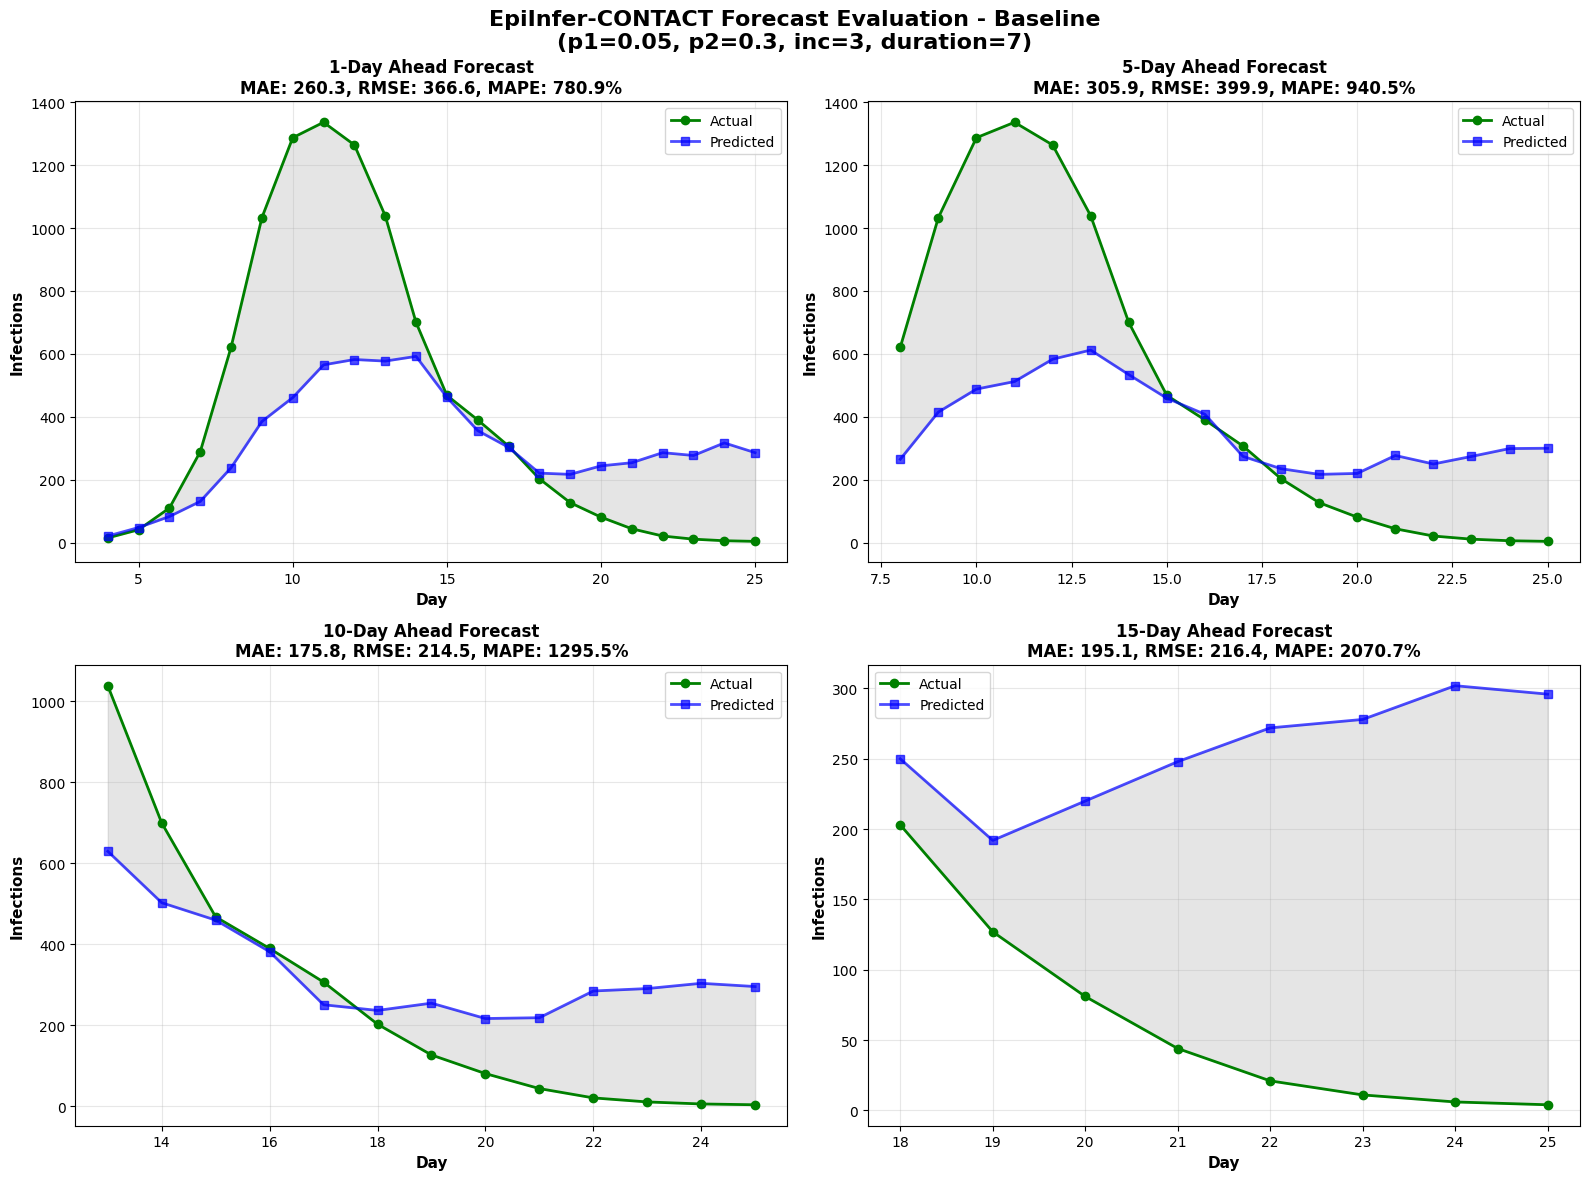

      - Saved forecast_comparison_baseline.png

Plot saved to forecast_comparison_higher_transmission.png


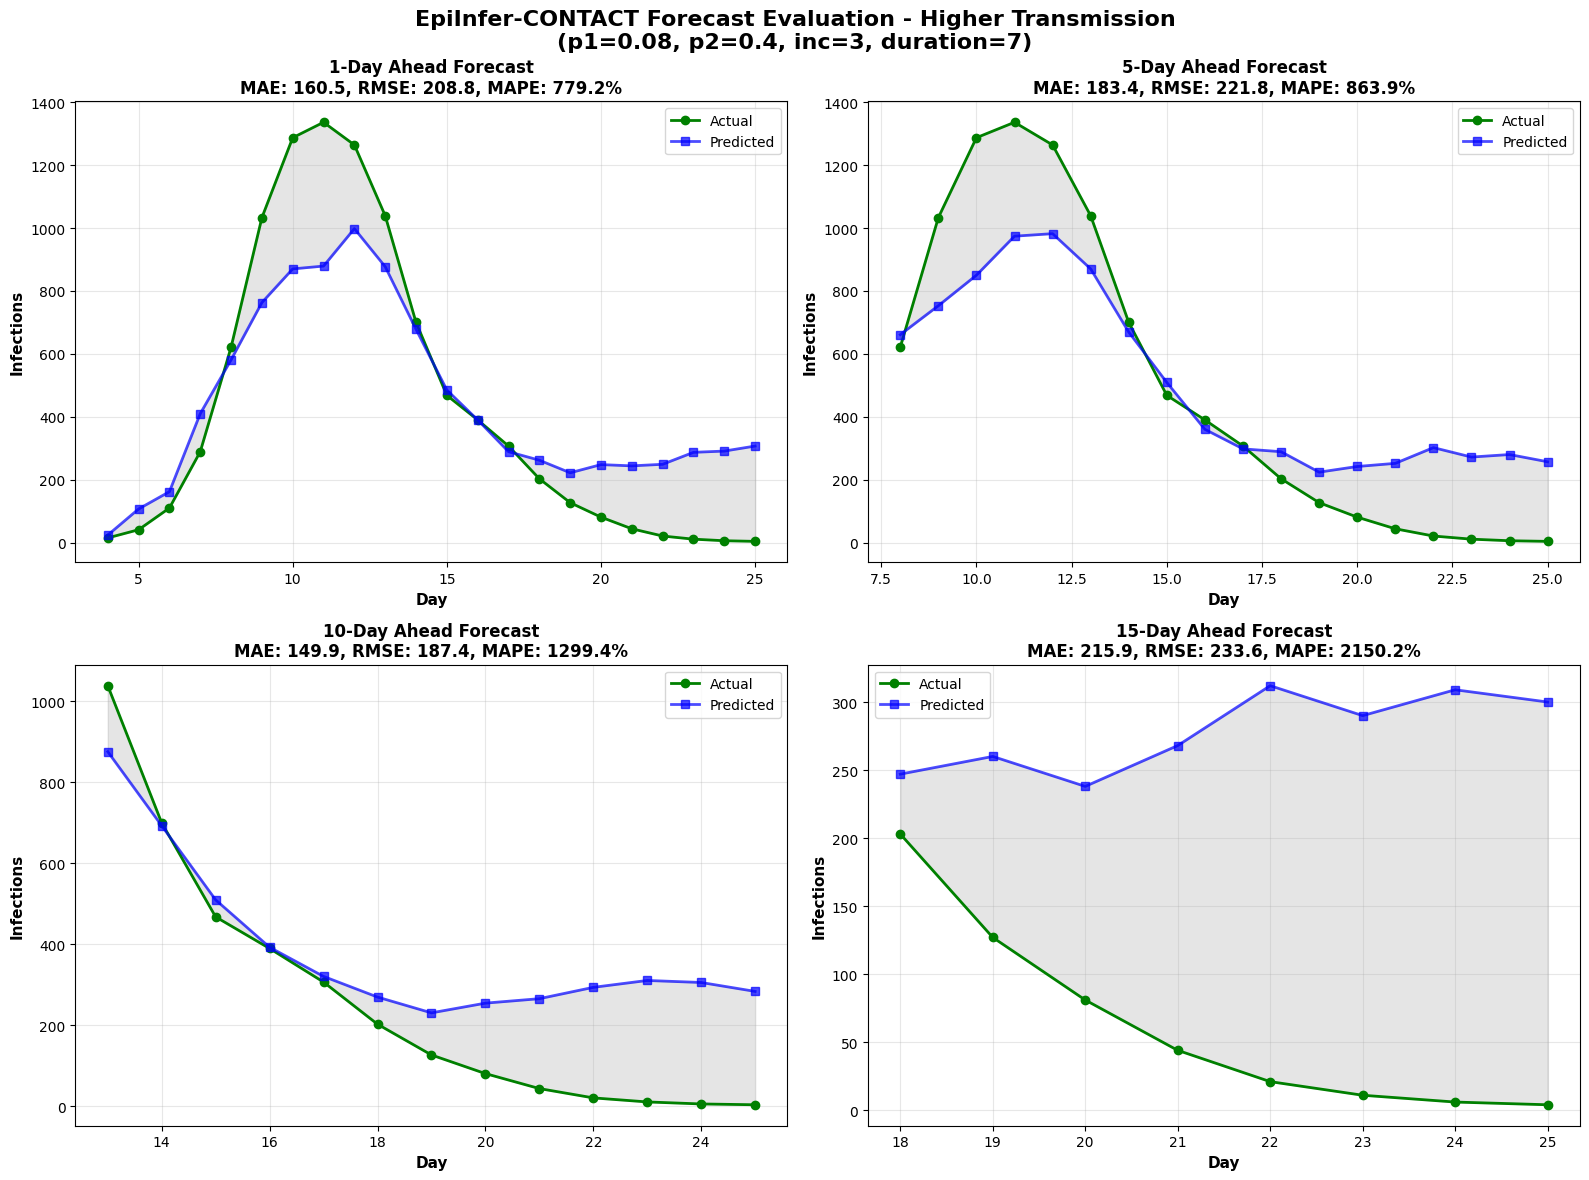

      - Saved forecast_comparison_higher_transmission.png

Plot saved to forecast_comparison_high_risk.png


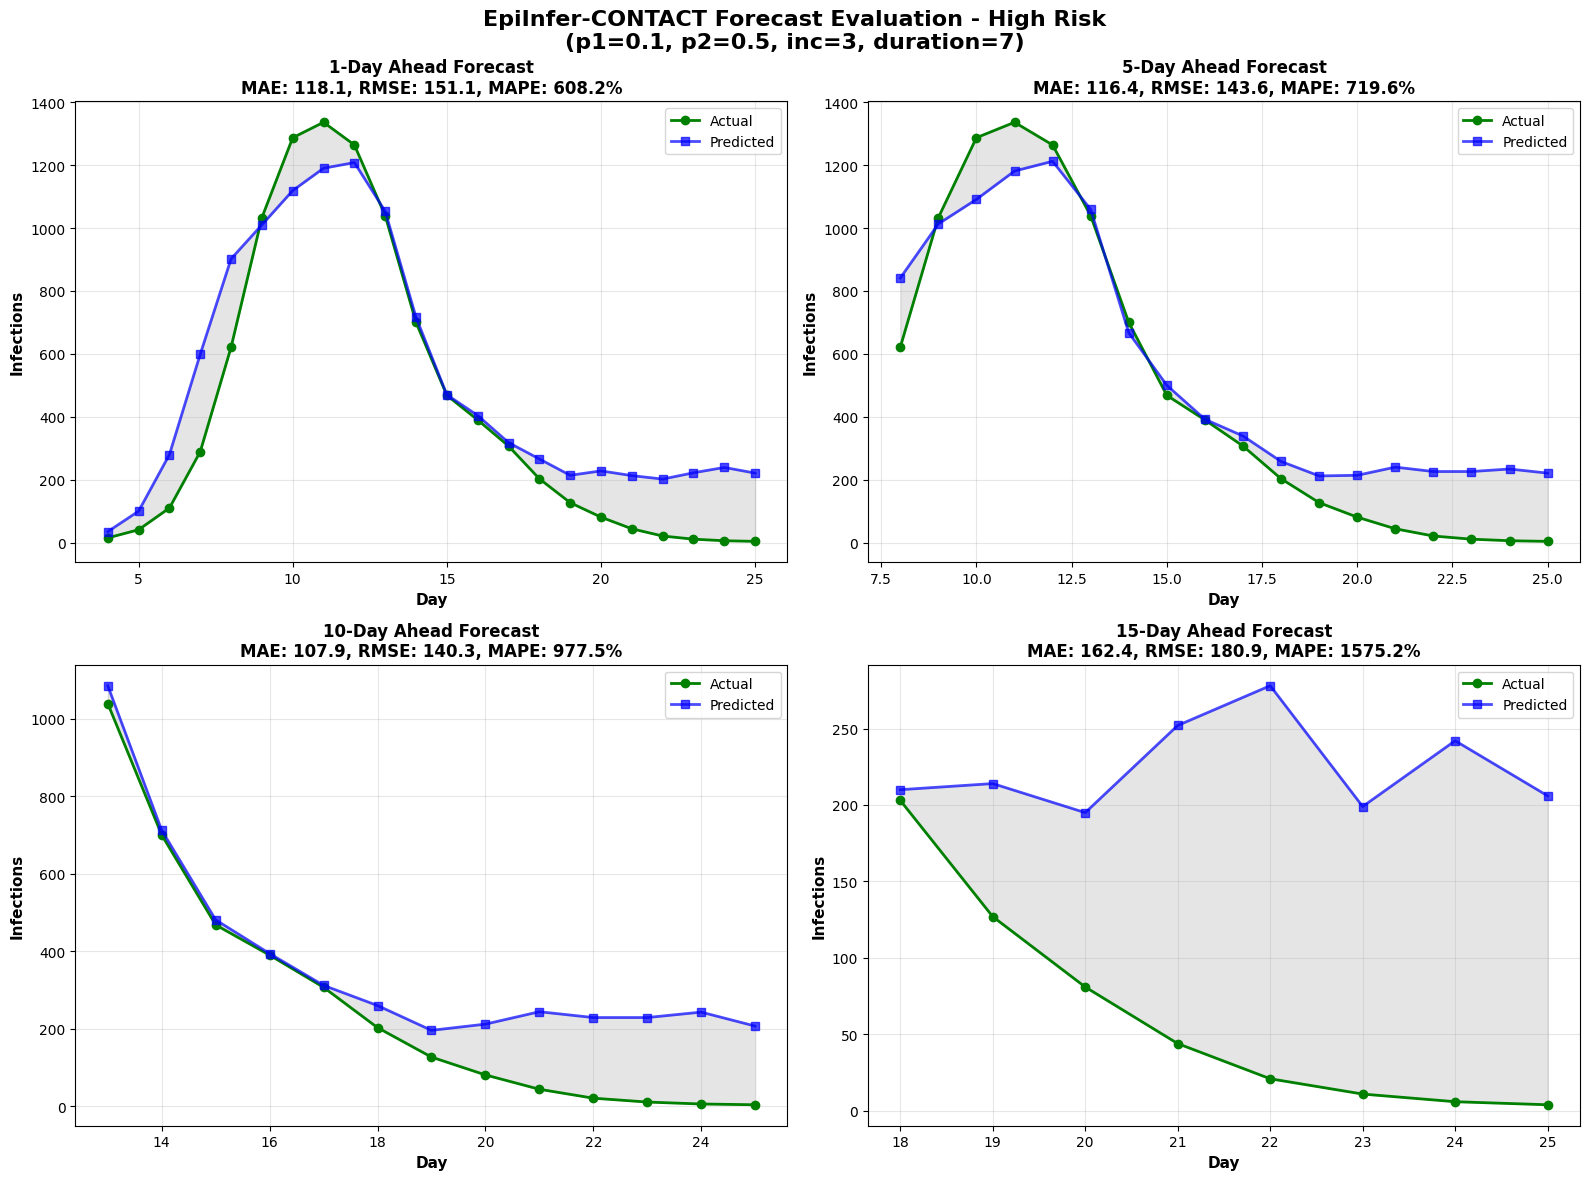

      - Saved forecast_comparison_high_risk.png

Plot saved to forecast_comparison_long_incubation.png


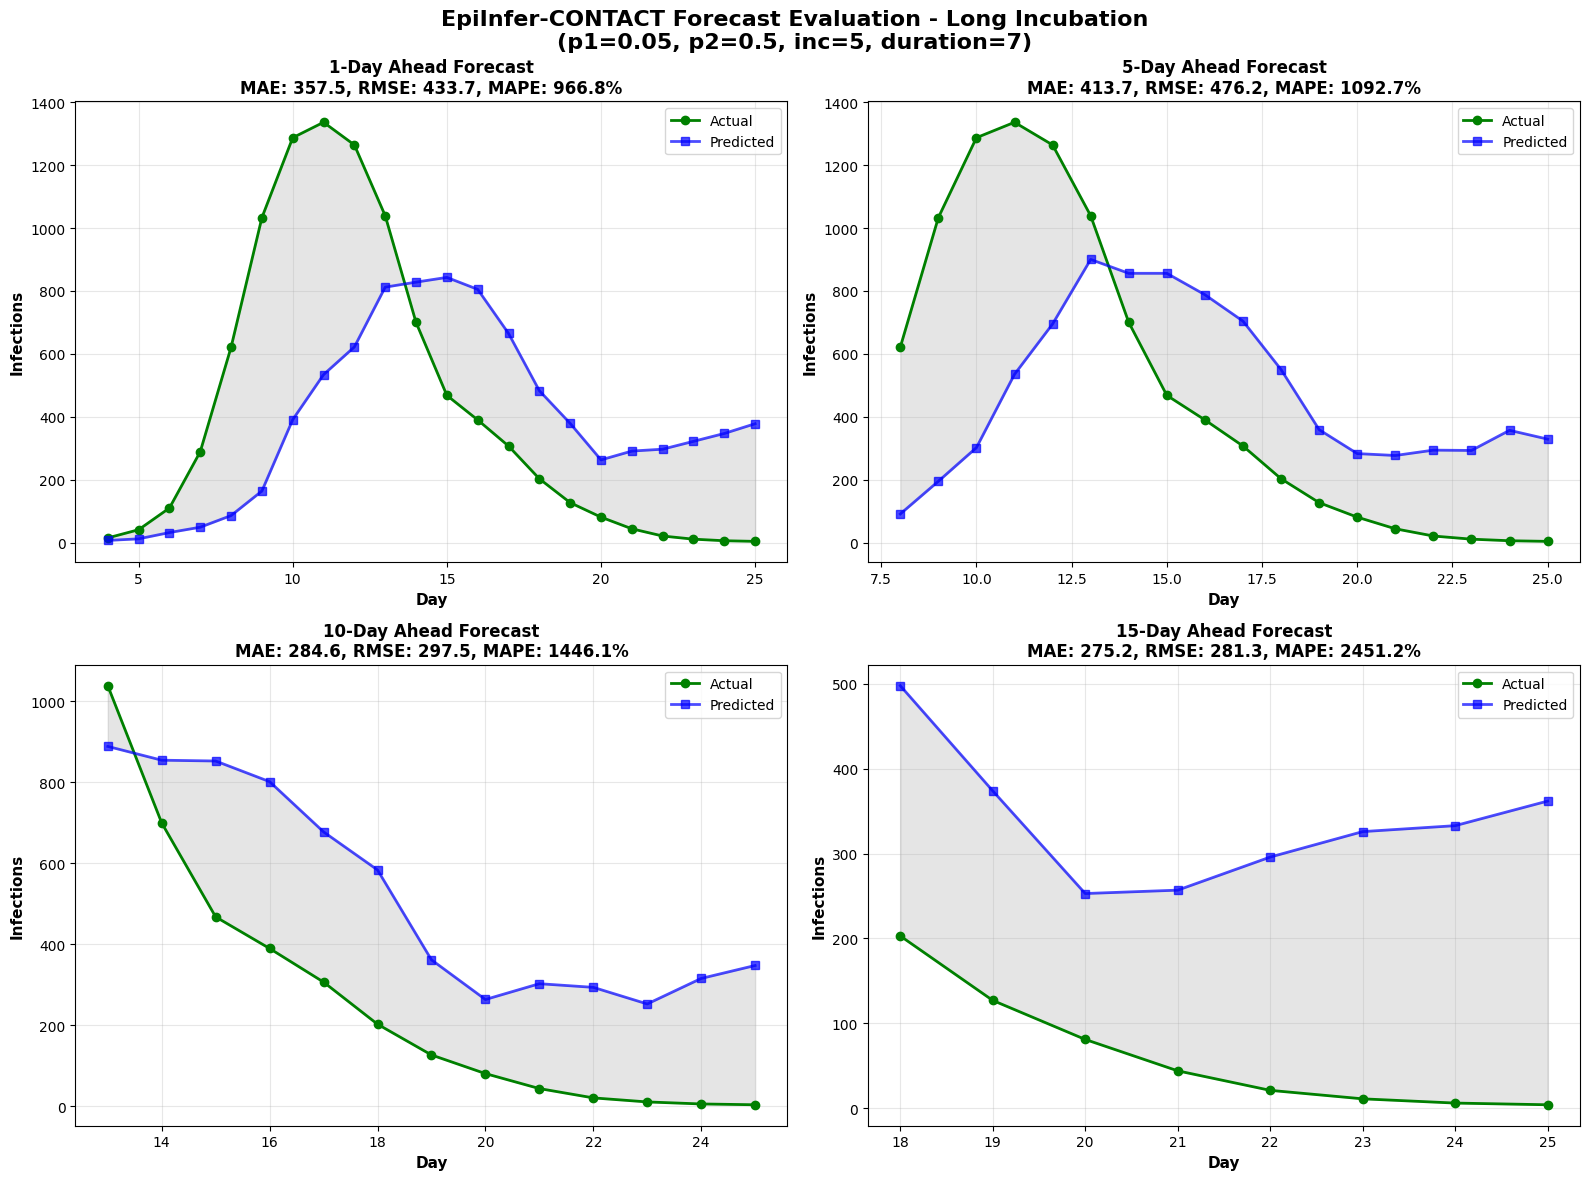

      - Saved forecast_comparison_long_incubation.png

Plot saved to forecast_comparison_extended_infection.png


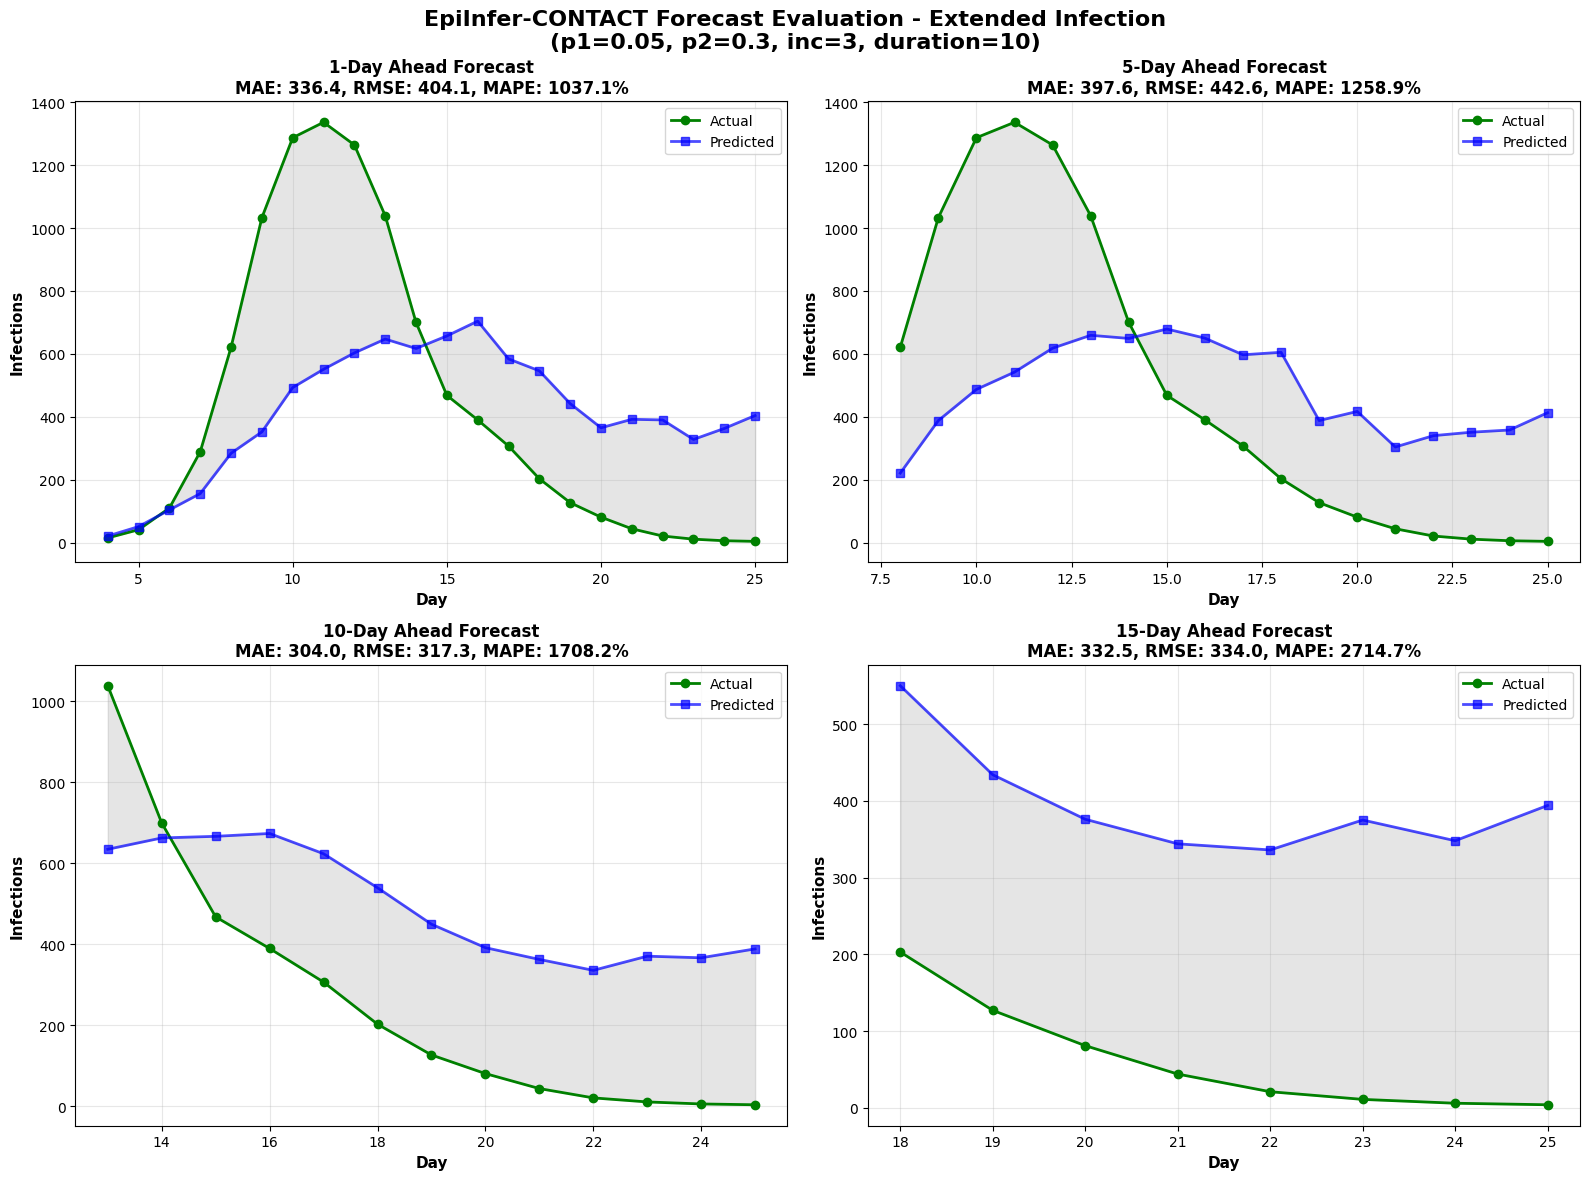

      - Saved forecast_comparison_extended_infection.png
Metrics comparison plot saved to metrics_comparison_all.png


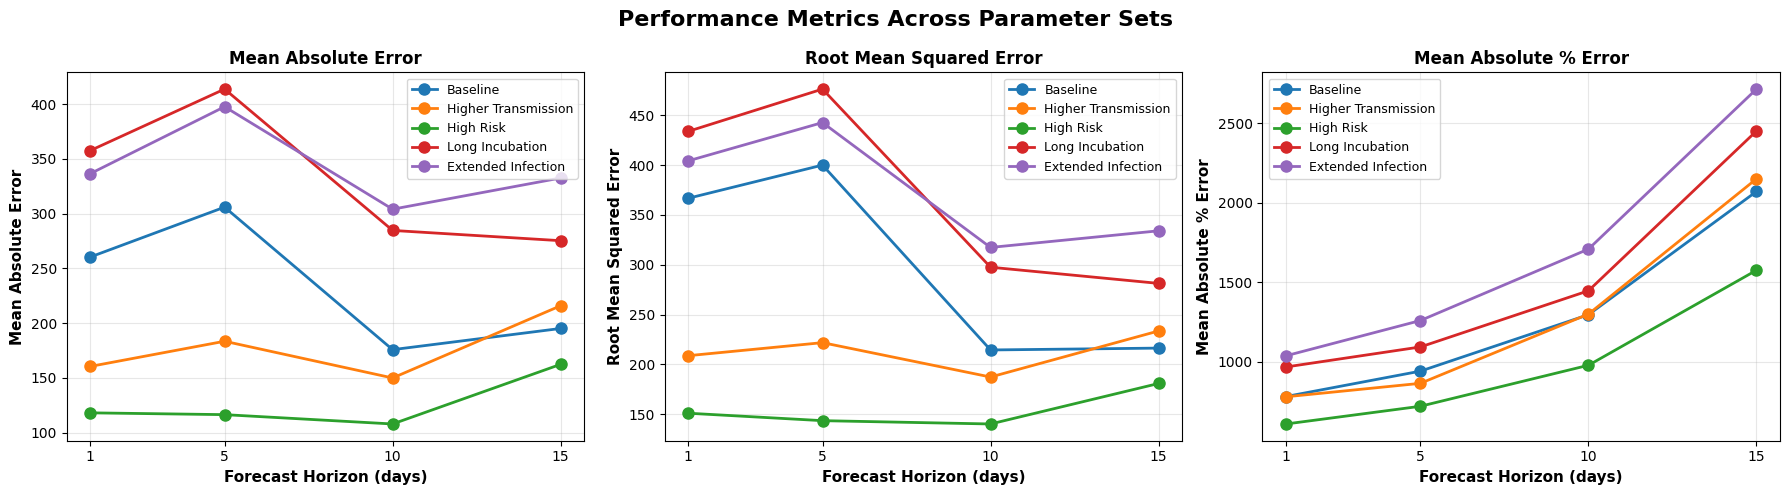


6. Saving summary results...
   Summary saved to evaluation_summary.csv

7. Method Comparison Summary (Baseline Parameters):
   Horizon          Method        MAE       RMSE       MAPE
----------------------------------------------------------------------
         1d   Contact-based     260.32     366.61     780.9%
         5d   Contact-based     305.89     399.93     940.5%
        10d   Contact-based     175.77     214.51    1295.5%
        15d   Contact-based     195.12     216.37    2070.7%

Evaluation Complete!


In [19]:
"""Main evaluation pipeline."""
print("="*70)
print("EpiInfer-CONTACT Evaluation Pipeline")
print("="*70)

# Load data
print("\n1. Loading data...")
states_df = load_states_data('states_total_25.csv')
contacts_per_day = load_contact_data('daily_contacts_multisheet_25.xlsx', max_days=25)
population = extract_population(contacts_per_day)
actual_infections = get_actual_infections(states_df)
actual_states = get_actual_states(states_df)

# Calculate mean meetings per day
print("\n   Calculating mean meetings per person per day...")
mean_meetings = calculate_mean_meetings(contacts_per_day, population)

print(f"   - Population size: {len(population)}")
print(f"   - Days of contact data: {len(contacts_per_day)}")
print(f"   - Days of infection data: {len(actual_infections)}")
print(f"   - Mean meetings calculated for {len(mean_meetings)} days")
print(f"   - Average meetings per person: {np.mean(list(mean_meetings.values())):.2f}")

# Initialize model
print("\n2. Initializing EpiInfer-CONTACT model...")
model = EpiInferContact(
    population=population,
    contacts_per_day=contacts_per_day,
    random_seed=42
)

# Define parameter combinations to test
param_sets = [
    {'name': 'Baseline', 'p1': 0.05, 'p2': 0.3, 'inc': 3, 'duration_infected': 7},
    {'name': 'Higher Transmission', 'p1': 0.08, 'p2': 0.4, 'inc': 3, 'duration_infected': 7},
    {'name': 'High Risk', 'p1': 0.10, 'p2': 0.5, 'inc': 3, 'duration_infected': 7},
    {'name': 'Long Incubation', 'p1': 0.05, 'p2': 0.5, 'inc': 5, 'duration_infected': 7},
    {'name': 'Extended Infection', 'p1': 0.05, 'p2': 0.3, 'inc': 3, 'duration_infected': 10},
]

horizons = [1, 5, 10, 15]

# Initial infected (from day 3 in states data)
initial_infected_ids = list(population)[:7]  # Approximation
initial_infected = set(initial_infected_ids)

results_by_params = {}

# Run evaluations for each parameter set
print("\n3. Running forecast evaluations...")
for param_set in param_sets:
    print(f"\n   Testing: {param_set['name']}")
    print(f"   Parameters: p1={param_set['p1']}, p2={param_set['p2']}, "
          f"inc={param_set['inc']}, duration={param_set['duration_infected']}")

    param_results = {}

    for horizon in horizons:
        print(f"      - Running {horizon}-day ahead forecasts...")

        # Method 1: Contact-based inference
        forecasts_contact = run_forecast_evaluation(
            model=model,
            p1=param_set['p1'],
            p2=param_set['p2'],
            inc=param_set['inc'],
            duration_infected=param_set['duration_infected'],
            initial_infected=initial_infected,
            max_day=25,
            actual_infections=actual_infections,
            forecast_horizon=horizon
        )

        # Method 2: Meeting distribution inference
        forecasts_epiinfer = run_epiinfer_evaluation(
            model=model,
            p1=param_set['p1'],
            p2=param_set['p2'],
            inc=param_set['inc'],
            mean_meetings=mean_meetings,
            actual_states=actual_states,
            max_day=25,
            forecast_horizon=horizon
        )

        metrics_contact = calculate_metrics(forecasts_contact)
        metrics_epiinfer = calculate_metrics(forecasts_epiinfer)

        param_results[horizon] = {
            'forecasts': forecasts_contact,
            'metrics': metrics_contact,
            'forecasts_epiinfer': forecasts_epiinfer,
            'metrics_epiinfer': metrics_epiinfer
        }

        print(f"         Contact-based:  MAE={metrics_contact['mae']:.2f}, "
              f"RMSE={metrics_contact['rmse']:.2f}, MAPE={metrics_contact['mape']:.1f}%")
        print(f"         Meeting-based:  MAE={metrics_epiinfer['mae']:.2f}, "
              f"RMSE={metrics_epiinfer['rmse']:.2f}, MAPE={metrics_epiinfer['mape']:.1f}%")

    results_by_params[param_set['name']] = param_results

# Print detailed tables for baseline parameters
print("\n4. Detailed Results for Baseline Parameters:")
baseline_results = results_by_params['Baseline']
for horizon in horizons:
    if horizon in baseline_results:
        print_forecast_table(
            baseline_results[horizon]['forecasts'],
            horizon,
            baseline_results[horizon]['metrics'],
            forecasts_alt=None, #baseline_results[horizon]['forecasts_epiinfer'],
            metrics_alt=None, #baseline_results[horizon]['metrics_epiinfer'],
            method_name="Contact-based",
            alt_method_name= "Meeting-based"
        )

# Create visualizations
print("\n5. Creating visualizations...")

# Generate plots for baseline parameters
# baseline_param_info = next((p for p in param_sets if p['name'] == 'Baseline'), None)
# plot_comparison(baseline_results, actual_infections,
#                'forecast_comparison_baseline.png',
#                param_info=baseline_param_info)
# plot_method_comparison(baseline_results, actual_infections,
#                       'method_comparison_baseline.png',
#                       param_info=baseline_param_info)
# plot_metrics_comparison(results_by_params, 'metrics_comparison_all.png')
# plot_error_heatmap(baseline_results, 'error_heatmap_baseline.png',
#                   param_info=baseline_param_info)

# Optional: Generate individual plots for all parameter sets
print("\n   Generating plots for all parameter sets...")
for param_set in param_sets:
    param_name = param_set['name']
    param_results = results_by_params[param_name]
    safe_name = param_name.lower().replace(' ', '_')

    plot_comparison(param_results, actual_infections,
                    f'forecast_comparison_{safe_name}.png',
                    param_info=param_set)
    print(f"      - Saved forecast_comparison_{safe_name}.png")
plot_metrics_comparison(results_by_params, 'metrics_comparison_all.png')
# plot_error_heatmap(baseline_results, 'error_heatmap_baseline.png',
#                   param_info=baseline_param_info)

# Save summary results
print("\n6. Saving summary results...")
summary_data = []
for param_name, param_results in results_by_params.items():
    for horizon, result in param_results.items():
        # Contact-based method
        summary_data.append({
            'parameter_set': param_name,
            'method': 'Contact-based',
            'horizon': horizon,
            'mae': result['metrics']['mae'],
            'rmse': result['metrics']['rmse'],
            'mape': result['metrics']['mape'],
            'num_forecasts': len(result['forecasts'])
        })
        # Meeting-based method
        summary_data.append({
            'parameter_set': param_name,
            'method': 'Meeting-based',
            'horizon': horizon,
            'mae': result['metrics_epiinfer']['mae'],
            'rmse': result['metrics_epiinfer']['rmse'],
            'mape': result['metrics_epiinfer']['mape'],
            'num_forecasts': len(result['forecasts_epiinfer'])
        })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('evaluation_summary.csv', index=False)
print("   Summary saved to evaluation_summary.csv")

# Print comparison summary
print("\n7. Method Comparison Summary (Baseline Parameters):")
print("="*70)
print(f"{'Horizon':>10} {'Method':>15} {'MAE':>10} {'RMSE':>10} {'MAPE':>10}")
print("-"*70)
for horizon in horizons:
    if horizon in baseline_results:
        metrics_c = baseline_results[horizon]['metrics']
        metrics_m = baseline_results[horizon]['metrics_epiinfer']
        print(f"{horizon:>10}d {'Contact-based':>15} {metrics_c['mae']:>10.2f} "
              f"{metrics_c['rmse']:>10.2f} {metrics_c['mape']:>9.1f}%")
        # print(f"{'':>10} {'Meeting-based':>15} {metrics_m['mae']:>10.2f} "
        #       f"{metrics_m['rmse']:>10.2f} {metrics_m['mape']:>9.1f}%")
        # print("-"*70)

print("\n" + "="*70)
print("Evaluation Complete!")
print("="*70)

## Data used

In [20]:
states_df

,day,S,E,I,R
0,0,1992,8,0,0
1,1,1980,20,0,0
2,2,1944,56,0,0
3,3,1850,143,7,0
4,4,1596,389,15,0
5,5,1127,832,41,0
6,6,563,1327,110,0
7,7,256,1455,289,0
8,8,211,1161,621,7
9,9,222,730,1033,15
